# Projet : Forage de données IFT870

# Augmentation de la région d'intérêt et partitionnement

Ce notebook contiendra des traces de la méthode utilisée pour augmenter la région d'intérêt de la tumeur.

### Installation des dépendances

In [2]:
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
import scipy.io
from scipy import ndimage
from pymatreader import read_mat
import math
from DataTransformation import *


# On se demande pourquoi pip install en windows powershell ne l'installe pas.
# !pip install pymatreader 

### Importation de données

In [3]:
nb_images = 3064

class_names = ['meningiome', 'gliome', 'pituitaire']

def load_data(type, nb_images=3064):
    data = {}
    if type == 'mat':
        for i in range(1, nb_images):
            dir = "dataset/Mat_Format_Dataset/" + str(i) + ".mat"
            data[i] = read_mat(dir)
        return data
    
    if type == 'png':
        class_nb = [1, 2, 3]    
        for i in range(len(class_nb)):
            dir = "dataset/png/" + str(class_nb[i])
            for path in os.listdir(dir):
                data[i] = io.imread(dir + "/" + path)
        return data


mat_data = load_data(type='mat')
# png_data = load_data(type='png', nb_images=2)

In [8]:
meningioma_dict, glioma_dict, pituitary_dict = classify_data(mat_data)
print(len(meningioma_dict))
print(len(glioma_dict))
print(len(pituitary_dict))

707
1426
930


### Rappel : Visualisation d'une donnée au format mat

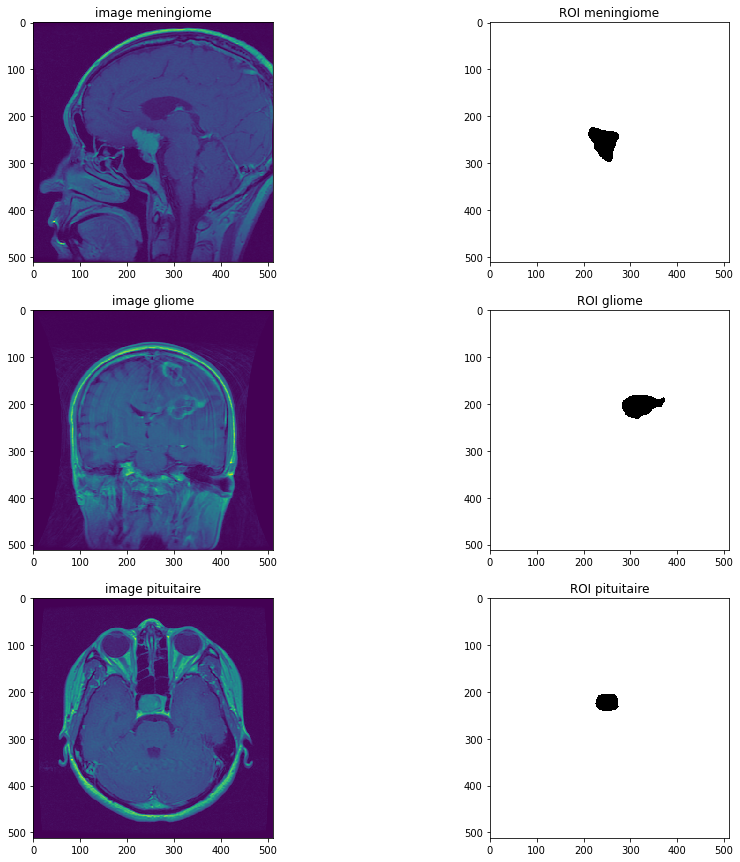

In [3]:
fig, axs = plt.subplots(3, 2, figsize=(15,15))

mats = []
labels = []
tumorMasks = []

# get one of each class
mats.append(mat_data[500])
mats.append(mat_data[800])
mats.append(mat_data[1000])

for i in range(len(class_names)):
    # mats.append(mat_data[i])
    labels.append(class_names[int(mats[i]["cjdata"]["label"]-1)])
    axs[i,0].imshow(mats[i]["cjdata"]['image'], interpolation='nearest')
    axs[i,0].title.set_text(str("image " + labels[int(mats[i]['cjdata']['label']-1)]))
    
    tumorMasks.append(mats[i]['cjdata']['tumorMask'])
    axs[i,1].imshow(tumorMasks[i], cmap='Greys', interpolation='nearest')
    axs[i,1].title.set_text(str('ROI '+ labels[int(mats[i]['cjdata']['label']-1)]))
    

### Dilatation avec un filtre carré et un filtre circulaire


Application de la dilatation


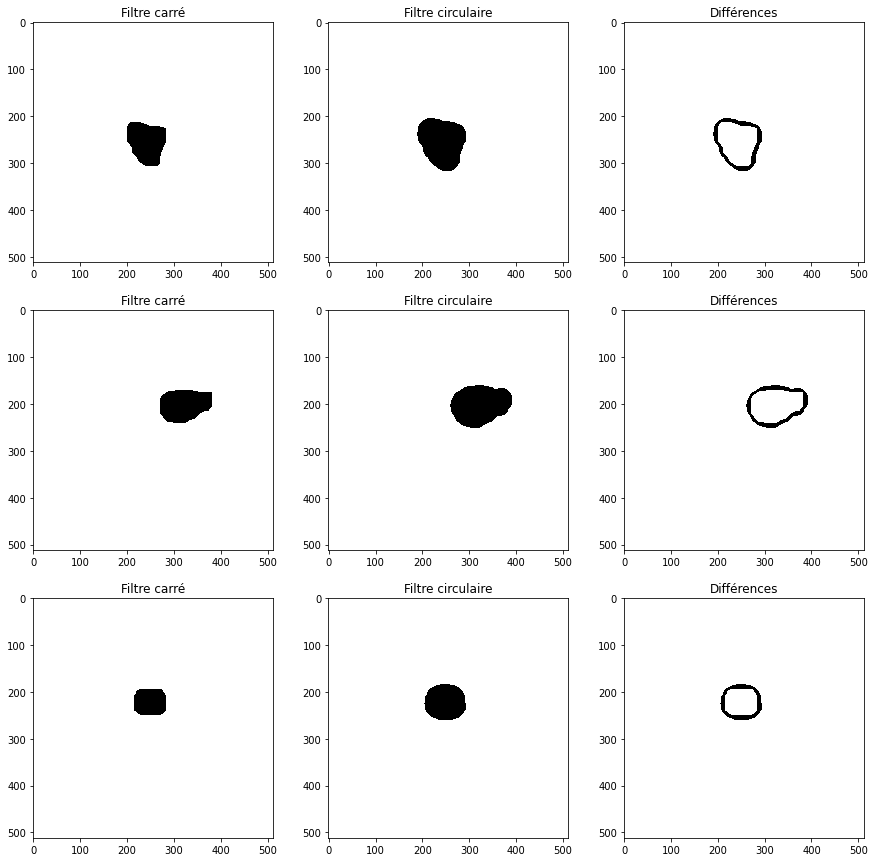

In [20]:
print('Application de la dilatation')

fig, axs = plt.subplots(3, 3, figsize=(15,15))

# Filtre circulaire
# https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

# Filtre carre
dilatedTumorMask_square = []
dilatedTumorMask_circle = []
dilation_structure = np.ones((20,20)) # square mask
circular_mask = create_circular_mask(40,40) # circular mask
for i in range(len(class_names)):
    # square
    dilatedTumorMask_square.append(ndimage.binary_dilation(tumorMasks[i], dilation_structure))
    axs[i,0].imshow(dilatedTumorMask_square[i], cmap='Greys', interpolation='nearest')
    axs[i,0].title.set_text('Filtre carré')
    
    # circular
    dilatedTumorMask_circle.append(ndimage.binary_dilation(tumorMasks[i], circular_mask))
    axs[i,1].title.set_text('Filtre circulaire')
    axs[i,1].imshow(dilatedTumorMask_circle[i], cmap='Greys', interpolation='nearest');
    
    # differences
    differences = np.logical_xor(dilatedTumorMask_square[i], dilatedTumorMask_circle[i])
    axs[i,2].title.set_text('Différences')
    axs[i,2].imshow(differences, cmap='Greys', interpolation='nearest');


### Partitionnement


In [19]:
# Cette fonction retourne une lise de couple au format [ [x1,y1], [x2,y2], ...,  [xn,yn] ]
def make_couple(data):
    # Verification
    if not( len(data) % 2 == 0):
        print('La dimension des données doit etre paire')
        return
    
    couples = []
    for i in range(int(len(data)/2.0)):
        couples.append([data[2*i], data[2*i + 1]])
    return couples

In [ ]:
def increase_contour_resolution(mat):
    """
    input:
        - data au format mat
    output:
        - aucun, mais la donnee mat aura son contour davantage discretise
    """
    border= mat['cjdata']['tumorBorder']
    border_couple = make_couple(border)
    for i in len(border_couple):
        delta_x = border_couple[i-1][0] - border_couple[i][0]
        delta_y = border_couple[i-1][1] - border_couple[i][1]
        dist = 
        
        
    

distribution de la distance


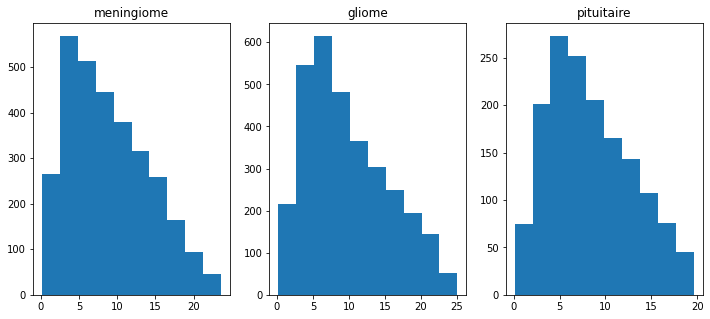

In [6]:
# Cette fonction calcule la distance la plus courte entre un element du mask et la bordure
#   border - doit etre sous format couple ( voir make_couple(data) )
#   mask_data - doit etre au format TRUE FALSE
def dist_elem_mask(border, mask_data):
    dim = len(mask_data)
    dist_mask = np.ndarray((dim,dim)) # distances with nan values
    min_distances = [] # distances only
    
    for x in range(dim):
        for y in range(dim):
            if mask_data[x][y] == 1:
                min_dist = float('inf')
                for border_point in border:
                    delta_x = abs(x - border_point[1])
                    delta_y = abs(y - border_point[0])
                    dist = (delta_x**2 + delta_y**2)**(1/2) # pythagore
                    if dist < min_dist:
                        min_dist = dist
                min_distances.append(min_dist)
                dist_mask[x][y] = min_dist
            else:
                dist_mask[x][y] = None
                
    return dist_mask, min_distances
print('distribution de la distance')

fig, axs = plt.subplots(1, 3, figsize=(12,5))

mask_with_distances = []
distances_only = []
for i in range(len(class_names)):
    border = make_couple(mats[i]['cjdata']['tumorBorder'])
    mask_dist, dist_only = dist_elem_mask(border, mats[i]['cjdata']['tumorMask'])
    mask_with_distances.append(mask_dist)
    distances_only.append(dist_only)
    axs[i].hist(dist_only)
    axs[i].title.set_text(class_names[i])

#### Attribution des zones

Visualisation du partitionnement


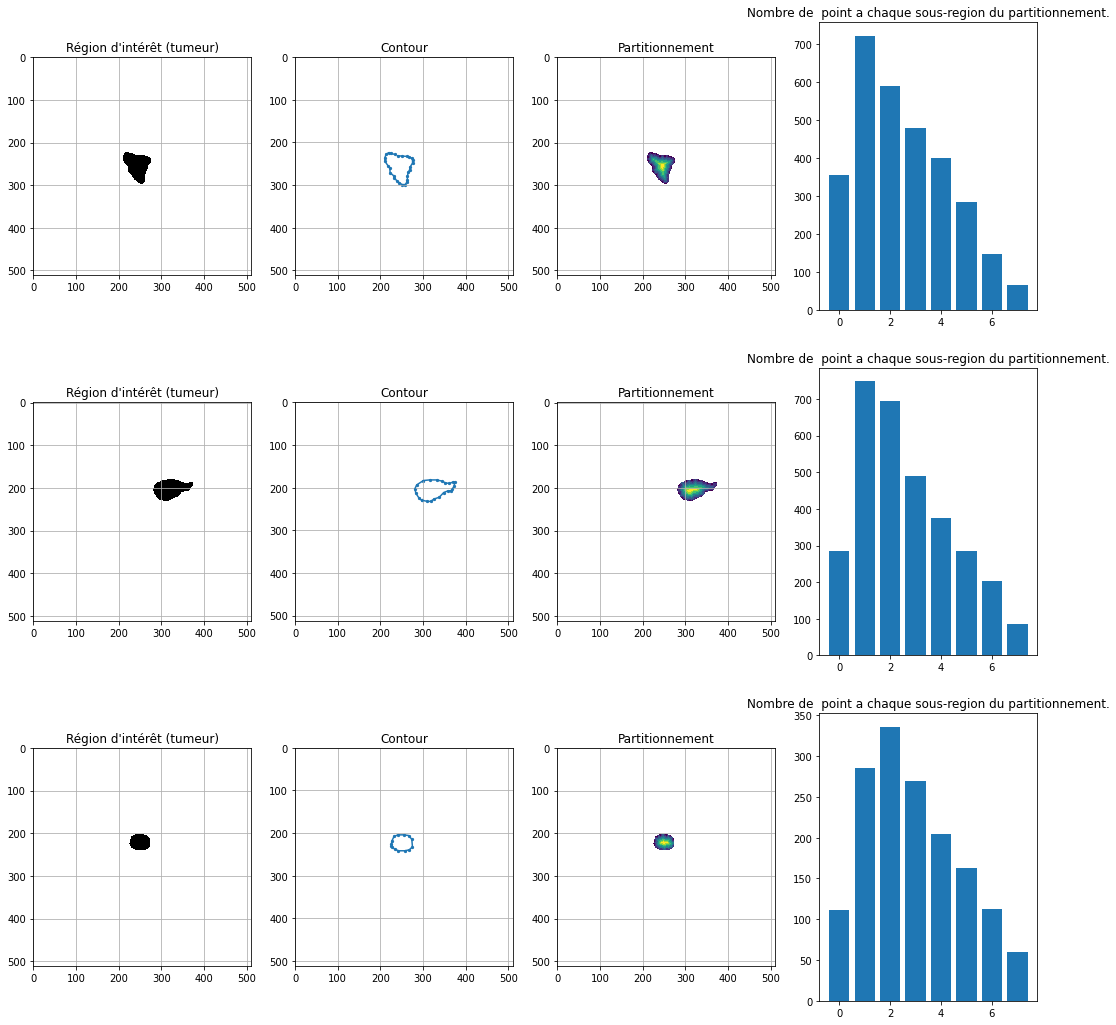

In [21]:
print('Visualisation du partitionnement')
def make_partition(mask_distances, level):
    min_dist = np.nanmin(mask_distances)
    max_dist = np.nanmax(mask_distances)
    interval_size = max_dist / (2**level)
    epsilon = 0.001 # epsilon to make the max value fall into the lowest category
    
    # correspond au masque, mais avec une valeur selon la proximite du contour
    # plus la valeur est petite, plus on est pres du contour (a l'exterieur)
    mask_levels = np.floor(np.subtract(mask_distances, epsilon) / interval_size)
    return mask_levels

def partition_distribution(mask_levels):
    level = int(math.log2(np.nanmax(mask_levels)+1))
    x = []
    distr = []
    for i in range(2**level):
        x.append(i)
        distr.append(np.count_nonzero(mask_levels == i))
    return x, distr

fig, axs = plt.subplots(3, 4, figsize=(18,18))
mask_levels = []
level = 3
for i in range(len(mats)):
    mask_levels.append(make_partition(mask_with_distances[i], level))

    axs[i,0].imshow(tumorMasks[i], cmap='Greys', interpolation='nearest')
    axs[i,0].title.set_text('Région d\'intérêt (tumeur)')
    axs[i,0].grid(True)
    
    border = np.array(mats[i]['cjdata']['tumorBorder'])
    border_couple = np.array(make_couple(border))
    axs[i,1].scatter(border_couple[:,0], border_couple[:,1],s=5)
    axs[i,1].plot(border_couple[:,0], border_couple[:,1])
    axs[i,1].set_xlim([0,512])
    axs[i,1].set_ylim([0,512])
    axs[i,1].invert_yaxis()
    axs[i,1].set(adjustable='box', aspect='equal')
    axs[i,1].title.set_text('Contour')
    axs[i,1].grid(True)
    
    axs[i,2].imshow(mask_levels[i], cmap='viridis', interpolation='nearest')
    axs[i,2].title.set_text('Partitionnement')
    axs[i,2].grid(True)
    
    x, distr = partition_distribution(mask_levels[i])
    axs[i,3].bar(x,distr)
    axs[i,3].title.set_text("Nombre de  point a chaque sous-region du partitionnement.")
    
    

    

### NOTES 
- **Partitionnement roi origine** : Pour l'instant, le partitionnement est réalisé à partir des roi d'origine, car nous n'avons pas encore trouvé de façon de faire pour dilaté le contour du mask au format [ [x1,y1], [x2,y2], ..., [xn,n] ]
- **Vitesse de calcul** : Plusieurs fonctions devraient être optimisées en utilisant des librairies comme numpy.
- **Contour discrétisé** : On suppose que la discrétisation du contour des tumeurs crée des forme concaves lors du partitionnement.